In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sympy as sy
import json
import pickle
import numexpr as ne

from time import time
from numpy import cos, sin
from tqdm import tqdm

from scipy.integrate import odeint, quad
from scipy.special import lpmn, lpmv, jv, jnyn_zeros, j0, j1

In [2]:
R_earth = 6400000
R_moon = 1737100
dist_moon = 380000000
R_m = 16 * R_earth
b = 5 * R_earth
g_10 = -29404.8 * 1e-9
g_11 = -1450.9 * 1e-9
h_11 = 4652.5 * 1e-9 
q = 1.6e-19 #Кл
m = 1.67e-27 #Кг
mu_0 = 4*np.pi * 1e-7 # Гн/м
m_x = 4*np.pi*R_earth**3 / mu_0 * g_11
m_y = 4*np.pi*R_earth**3 / mu_0 * h_11
m_z = 4*np.pi*R_earth**3 / mu_0 * g_10

In [207]:
class MagnetField:

    def __init__(self, N=10):

        self.N = N
        self.ns = np.arange(1, N+1)
        self.a_0, self.a_1, self.x_0, self.x_1 = self.create_const_a(N=N)
        self.R_m_arr = np.array([R_m]*N)
        self.m_x_arr = np.array([m_x]*N)
        self.m_y_arr = np.array([m_y]*N)
        self.m_z_arr = np.array([m_z]*N)
        self.mu_0_arr = np.array([mu_0]*N)
        

    def create_start_points_for_particles(self, r_upbound=1.01 * R_earth, r_nums=1,
                                          thetha_nums=2, phi_nums=4, thetha_v_nums=3, phi_v_nums=3, save=False,
                                          name='magnetic.json'):
        theta = np.concatenate((np.linspace(0, np.pi / 8, num=thetha_nums),
                                np.linspace(np.pi, np.pi + np.pi / 8, num=thetha_nums)))
        phi = np.linspace(0, 2 * np.pi, num=phi_nums)
        r = np.linspace(1.01 * R_earth, r_upbound, num=r_nums)
        theta_v = np.linspace(0, np.pi, num=thetha_v_nums)
        phi_v = np.linspace(0, 2 * np.pi, num=phi_v_nums)

        if save:
            data = {'thethas': theta,
                    'phies': phi,
                    'radius': r,
                    'thethas_v': theta_v,
                    'phies_v': phi_v
                    }
            with open(name, 'w') as f:
                json.dump(data, f, indent=2,
                          cls=NumpyEncoder)
            return

        return theta, phi, r, theta_v, phi_v

    @staticmethod
    def make_start_points_for_magnetosphere(thetha_nums=10, phi_nums=10):
        theta = np.linspace(0, np.pi, num=thetha_nums)
        phi = np.linspace(0, 2 * np.pi, num=phi_nums)
        r = np.linspace(R_earth, R_earth, num=1)

        th, ph, rr = np.meshgrid(theta, phi, r)

        th = np.expand_dims(th, axis=-1)
        ph = np.expand_dims(ph, axis=-1)
        rr = np.expand_dims(rr, axis=-1)

        start_points = np.concatenate((rr, th, ph), axis=-1)
        start_points = start_points.reshape(-1, 3)
        return start_points

    @staticmethod
    def create_const_a(N=100):
        jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(0, 10)
        x_0 = jnp_roots
        jn_roots, jnp_roots, yn_roots, ynp_roots = jnyn_zeros(1, 10)
        x_1 = jnp_roots

        def f0(x):
            S = -b / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += -1 / b ** 2 * (n + 1) * (-b / R_m) ** (n + 1) * (x / R_m) ** n * lpmv(0, n, 0)
            return S

        def f1(x):
            S = x / (b ** 2 + x ** 2) ** (3 / 2)
            for n in range(1, 100):
                S += 1 / b ** 2 * (n + 1) / n * (-b / R_m) ** (n + 1) * (x / R_m) ** n * (-lpmv(1, n, 0))
            return S

        def func(x, x_nn, v):
            if v == 0:
                return x * jv(0, x_nn * x / R_m) * f0(x)
            else:
                return x * jv(1, x_nn * x / R_m) * f1(x)

        a_0 = np.array([2 / (R_m ** 2 * jv(0, x_0[n]) ** 2) * quad(func, 0, R_m, args=(x_0[n], 0))[0] for n in
                        tqdm(range(N), desc="Подсчет a_0")])
        a_1 = np.array(
            [2 / (R_m ** 2 * jv(1, x_1[n]) ** 2 * (1 - (1 / x_1[n]) ** 2)) * quad(func, 0, R_m, args=(x_1[n], 1))[0] for
             n in tqdm(range(N), desc="Подсчет a_1")])
        return a_0, a_1, x_0, x_1

    @staticmethod
    def legs(theta):

        cos_theta = cos(theta)
        sin_theta = sin(theta)

        legs_0n = np.array([cos_theta, 1 / 2 * (3 * cos_theta ** 2 - 1),
                            1 / 2 * (5 * cos_theta ** 3 - 3 * cos_theta),
                            1 / 8 * (35 * cos_theta ** 4 - 30 * cos_theta ** 2 + 3),
                            1 / 8 * (63 * cos_theta ** 5 - 70 * cos_theta ** 3 + 15 * cos_theta),
                            1 / 16 * (231 * cos_theta ** 6 - 315 * cos_theta ** 4 + 105 * cos_theta ** 2 - 5),
                            1 / 16 * (
                                        429 * cos_theta ** 7 - 693 * cos_theta ** 5 + 315 * cos_theta ** 3 - 35 * cos_theta),
                            1 / 128 * (
                                        6435 * cos_theta ** 8 - 12012 * cos_theta ** 6 + 6930 * cos_theta ** 4 - 1260 * cos_theta ** 2 + 35),
                            1 / 128 * (
                                        12155 * cos_theta ** 9 - 25740 * cos_theta ** 7 + 18018 * cos_theta ** 5 - 4620 * cos_theta ** 3 + 315 * cos_theta),
                            1 / 256 * (
                                        46189 * cos_theta ** 10 - 109395 * cos_theta ** 8 + 90090 * cos_theta ** 6 - 30030 * cos_theta ** 4 + 3465 * cos_theta ** 2 - 63)]
                           )
        legs_1n = np.array([np.abs(sin_theta), 3 * cos_theta * np.abs(sin_theta),
                            3 / 2 * np.abs(sin_theta) * (5 * cos_theta ** 2 - 1),
                            5 / 2 * np.abs(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                            15 / 8 * np.abs(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                            21 / 8 * np.abs(sin_theta) * (33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                            7 / 16 * np.abs(sin_theta) * (
                                        429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                            9 / 16 * np.abs(sin_theta) * (
                                        715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                            45 / 128 * np.abs(sin_theta) * (
                                        2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                            55 / 128 * np.abs(sin_theta) * (
                                        4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                           )
        divlegs_0n = np.array([-sin_theta, -3 * sin_theta * cos_theta,
                               -3 / 2 * sin_theta * (5 * cos_theta ** 2 - 1),
                               -5 / 2 * sin_theta * cos_theta * (7 * cos_theta ** 2 - 3),
                               -15 / 8 * sin_theta * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                               -21 / 8 * sin_theta * cos_theta * (33 * cos_theta ** 4 - 30 * cos_theta ** 2 + 5),
                               -7 / 16 * sin_theta * (
                                           429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                               -9 / 16 * sin_theta * cos_theta * (
                                           715 * cos_theta ** 6 - 1001 * cos_theta ** 4 + 385 * cos_theta ** 2 - 35),
                               -45 / 128 * sin_theta * (
                                           2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                               -55 / 128 * sin_theta * cos_theta * (
                                           4199 * cos_theta ** 8 - 7956 * cos_theta ** 6 + 4914 * cos_theta ** 4 - 1092 * cos_theta ** 2 + 63)]
                              )
        divlegs_1n = np.array([cos_theta * np.sign(sin_theta), -3 * np.sign(sin_theta) * (1 - 2 * cos_theta ** 2),
                               -3 / 2 * np.sign(sin_theta) * cos_theta * (11 - 15 * cos_theta ** 2),
                               5 / 2 * np.sign(sin_theta) * (28 * cos_theta ** 4 - 27 * cos_theta ** 2 + 3),
                               15 / 8 * np.sign(sin_theta) * cos_theta * (
                                           105 * cos_theta ** 4 - 126 * cos_theta ** 2 + 29),
                               21 / 8 * np.sign(sin_theta) * (
                                           198 * cos_theta ** 6 - 285 * cos_theta ** 4 + 100 * cos_theta ** 2 - 5),
                               7 / 16 * np.sign(sin_theta) * cos_theta * (
                                           3003 * cos_theta ** 6 - 5049 * cos_theta ** 4 + 2385 * cos_theta ** 2 - 275),
                               9 / 16 * np.sign(sin_theta) * (
                                           5720 * cos_theta ** 8 - 11011 * cos_theta ** 6 + 6545 * cos_theta ** 4 - 1225 * cos_theta ** 2 + 35),
                               45 / 128 * np.sign(sin_theta) * cos_theta * (
                                           21879 * cos_theta ** 8 - 47476 * cos_theta ** 6 + 34034 * cos_theta ** 4 - 8932 * cos_theta ** 2 + 623),
                               55 / 128 * np.sign(sin_theta) * (
                                           41990 * cos_theta ** 10 - 101439 * cos_theta ** 8 + 85176 * cos_theta ** 6 - 28938 * cos_theta ** 4 + 3402 * cos_theta ** 2 - 63)]
                              )
        legs_1n_div_sin = np.array([np.sign(sin_theta), 3 * cos_theta * np.sign(sin_theta),
                                    3 / 2 * np.sign(sin_theta) * (5 * cos_theta ** 2 - 1),
                                    5 / 2 * np.sign(sin_theta) * (7 * cos_theta ** 3 - 3 * cos_theta),
                                    15 / 8 * np.sign(sin_theta) * (21 * cos_theta ** 4 - 14 * cos_theta ** 2 + 1),
                                    21 / 8 * np.sign(sin_theta) * (
                                                33 * cos_theta ** 5 - 30 * cos_theta ** 3 + 5 * cos_theta),
                                    7 / 16 * np.sign(sin_theta) * (
                                                429 * cos_theta ** 6 - 495 * cos_theta ** 4 + 135 * cos_theta ** 2 - 5),
                                    9 / 16 * np.sign(sin_theta) * (
                                                715 * cos_theta ** 7 - 1001 * cos_theta ** 5 + 385 * cos_theta ** 3 - 35 * cos_theta),
                                    45 / 128 * np.sign(sin_theta) * (
                                                2431 * cos_theta ** 8 - 4004 * cos_theta ** 6 + 2002 * cos_theta ** 4 - 308 * cos_theta ** 2 + 7),
                                    55 / 128 * np.sign(sin_theta) * (
                                                4199 * cos_theta ** 9 - 7956 * cos_theta ** 7 + 4914 * cos_theta ** 5 - 1092 * cos_theta ** 3 + 63 * cos_theta)]
                                   )

        return legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin

    def fast_legs(self, theta):
        ([legs_0n, legs_1n], [divlegs_0n, divlegs_1n]) = lpmn(1, 10, cos(theta))
        return legs_0n[1:], -legs_1n[1:], (-divlegs_0n * sin(theta))[1:], (divlegs_1n * sin(theta))[1:], -legs_1n[1:] / sin(theta)

    def choose_legs(self, theta, eps=1e-5):
        if theta < eps:
            return self.legs(theta)
        return self.fast_legs(theta)

    def sphere_to_decart(self, point, B):
        r, theta, phi = point
        C = np.array([[sin(theta) * cos(phi), sin(theta) * sin(phi), cos(theta)],
                      [cos(theta) * cos(phi), cos(theta) * sin(phi), -sin(theta)],
                      [-sin(phi), cos(phi), 0]])
        B_xyz = B @ C
        point_xyz = np.array([r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)])
        return B_xyz, point_xyz

    def decart_to_sphere(self, x, y, z, eps=1e-8):
        r = np.sqrt(x ** 2 + y ** 2 + z ** 2)
        theta = np.arccos(z / r)
        phi = np.arctan(y / x) if x > 0 else np.arctan(y / x) + np.pi
        return np.array([r, theta, phi])

    def spher_to_cyl(self, point):
        r, theta, phi = point

        rho = r * sin(theta)
        phi = phi
        z = r * cos(theta)

        return rho, phi, z
    
    def conf_B_tail(self, point, lambd):
        rho, phi, z = self.spher_to_cyl(point)

        jv_1x_0 = j1(self.x_0[:self.N] * rho / R_m)
        jv_1x_1 = j1(self.x_1[:self.N] * rho / R_m)
        jv_0x_1 = j0(self.x_1[:self.N] * rho / R_m)
        jv_0x_0 = j0(self.x_0[:self.N] * rho / R_m)
        jv_2x_1 = jv(2, self.x_1[:self.N] * rho / R_m)

        cos_phi = np.array([cos(phi)]*self.N)
        sin_phi = np.array([sin(phi)]*self.N)
        expx_1 = np.exp(-self.x_1[:self.N] * z / R_m)
        expx_0 = np.exp(-self.x_0[:self.N] * z / R_m)
        explambdx_1 = np.exp(-lambd * self.x_1[:self.N] * z / R_m)
        explambdx_0 = np.exp(-lambd * self.x_0[:self.N] * z / R_m)
        mu_0_arr = np.array([mu_0/(4*np.pi)]*self.N)

        res = np.sum([mu_0_arr / self.R_m_arr * (
                     (self.x_0 * self.a_0 * self.m_x_arr  * jv_1x_0 * (expx_0 + lambd*explambdx_0)
                      + 0.5 * self.x_1 * self.a_1 * (self.m_z_arr * cos_phi + self.m_y_arr * sin_phi)* (jv_2x_1 - jv_0x_1) * (expx_1 + lambd*explambdx_1)
                                                 )
                       ),
                     self.a_1 * mu_0_arr / rho * (
                         (self.m_z_arr * sin_phi - self.m_y_arr * cos_phi)* jv_1x_1 * (expx_1 + lambd * explambdx_1)
                       ),
                      mu_0_arr / self.R_m_arr * (
                          self.x_0  * self.a_0 * self.m_x_arr * jv_0x_0 * (expx_0 + explambdx_0)
                          + self.x_1 * self.a_1 * (self.m_z_arr * cos_phi + self.m_y_arr * sin_phi) * jv_1x_1 * (expx_1 + explambdx_1)
                                             )
                       ], axis=1) / 2
        return res

    def cyl_to_dec(self, point, B):
        rho, phi, z = self.spher_to_cyl(point)
        C = np.array([[cos(phi), -sin(phi), 0],
                      [sin(phi), cos(phi), 0],
                      [0, 0, 1]])
        B_xyz = C @ B
        point_xyz = np.array([rho * cos(phi), rho * sin(phi), z])
        return B_xyz, point_xyz

    def conf_B_sphere_cfa(self, point, B_imf_xyz):
        r, theta, phi = point

        legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = self.choose_legs(theta)
        B_cfa_r = - (R_m / r) ** 3 * (
                    B_imf_xyz[2] * legs_0n[0] + B_imf_xyz[0] * cos(phi) * legs_1n[0] + B_imf_xyz[1] * sin(phi) *
                    legs_1n[0])
        B_cfa_theta = 0.5 * (R_m / r) ** 3 * (
                    B_imf_xyz[2] * divlegs_0n[0] + B_imf_xyz[0] * cos(phi) * divlegs_1n[0] + B_imf_xyz[1] * sin(phi) *
                    divlegs_1n[0])
        B_cfa_phi = 0.5 * (R_m / r) ** 3 * (
                    -B_imf_xyz[0] * sin(phi) * legs_1n_div_sin[0] + B_imf_xyz[1] * cos(phi) * legs_1n_div_sin[0])
        return np.array([B_cfa_r, B_cfa_theta, B_cfa_phi])

    def conf_B_cyl_cfa(self, point, B_imf_xyz):
        rho, phi, z = self.spher_to_cyl(point)
        B_cfa_rho = - (R_m / rho) ** 2 * (B_imf_xyz[0] * cos(phi) + B_imf_xyz[1] * sin(phi))
        B_cfa_phi = (R_m / rho) ** 2 * (-B_imf_xyz[0] * sin(phi) + B_imf_xyz[1] * cos(phi))
        B_cfa_z = 0
        return np.array([B_cfa_rho, B_cfa_phi, B_cfa_z])

    @staticmethod
    def conf_B_dip_xyz_M(point):
        r_M, theta_M, phi_M = point
        x_M, y_M, z_M = r_M * sin(theta_M) * cos(phi_M), r_M * sin(theta_M) * sin(phi_M), r_M * cos(theta_M)

        r = np.sqrt((z_M + b) ** 2 + y_M ** 2 + x_M ** 2)

        B_x = -(R_earth / r) ** 3 * g_10 + 3 * R_earth ** 3 / r ** 5 * x_M * (
                    -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
        B_y = -(R_earth / r) ** 3 * h_11 + 3 * R_earth ** 3 / r ** 5 * y_M * (
                    -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
        B_z = (R_earth / r) ** 3 * g_11 + 3 * R_earth ** 3 / r ** 5 * (z_M + b) * (
                    -g_11 * (z_M + b) + y_M * h_11 + x_M * g_10)
        return np.array([B_x, B_y, B_z]), np.array([x_M, y_M, z_M])

    def conf_B_cfi_N(self, point):
        r, theta, phi = point  # r_m, theta_m, phi_m

        legs_0n, legs_1n, divlegs_0n, divlegs_1n, legs_1n_div_sin = self.choose_legs(theta)
        cos_phi = cos(phi)
        sin_phi = sin(phi)
        mu_0_with_b = mu_0 / (4 * np.pi * b ** 3)
        
        res = np.sum([mu_0_with_b * (self.ns + 1) * (-b / R_m) ** (self.ns + 2) * (r / R_m) ** (self.ns - 1) * (
                          -self.ns * m_x * legs_0n[:self.N] + (m_z * cos_phi + m_y * sin_phi) * legs_1n[:self.N]
                  ),
                  mu_0_with_b * (self.ns + 1) / self.ns * (-b / R_m) ** (self.ns + 2) * (r / R_m) ** (self.ns - 1) * (
                          -self.ns * m_x * divlegs_0n[:self.N] + (m_z * cos_phi + m_y * sin_phi) * divlegs_1n[:self.N]
                  ),
                  mu_0_with_b * (self.ns + 1) / self.ns * (-b / R_m) ** (self.ns + 2) * (r / R_m) ** (self.ns - 1) * (
                          (-m_z * sin_phi + m_y * cos_phi) * legs_1n_div_sin[:self.N])], axis=1)

        return res

    def conf_B(self, point_xyz, C_i, C_a, lambd, B_imf_xyz):
        point = self.decart_to_sphere(*point_xyz)  # x_m, y_m, z_m -> r_m, theta_m, phi_m

        # проверка в цилиндре мы или в полусфере
        if point_xyz[-1] < 0 and point[0] < R_m:

            B_dip_xyz, point_dip_xyz = self.conf_B_dip_xyz_M(point)

            B_cfi = self.conf_B_cfi_N(point)
            B_cfi_xyz, point_cfi_xyz = self.sphere_to_decart(point, B_cfi)

            B_xyz = B_dip_xyz + (1 - C_i) * B_cfi_xyz + C_a * B_imf_xyz
        elif point_xyz[-1] > 0 and point[0] * sin(point[1]) < R_m:

            B_tail = self.conf_B_tail(point, lambd)
            B_tail_xyz, point_tail_xyz = self.cyl_to_dec(point, B_tail)

            B_xyz = B_tail_xyz + C_a * B_imf_xyz
        elif point_xyz[-1] < 0 and point[0] >= R_m:
            B_cfa = self.conf_B_sphere_cfa(point, B_imf_xyz)
            B_cfa_xyz, point_cfa_xyz = self.sphere_to_decart(point, B_cfa)

            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_xyz
        else:
            B_cfa_cyl = self.conf_B_cyl_cfa(point, B_imf_xyz)
            B_cfa_cyl_xyz, point_cfa_cyl_xyz = self.cyl_to_dec(point, B_cfa_cyl)

            B_xyz = B_imf_xyz + (1 - C_a) * B_cfa_cyl_xyz

        return B_xyz

    @staticmethod
    def make_Earth(data=None):
        def ms(x, y, z, radius, resolution=20):
            """Return the coordinates for plotting a sphere centered at (x,y,z)"""
            u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
            X = radius * np.cos(u) * np.sin(v) + x
            Y = radius * np.sin(u) * np.sin(v) + y
            Z = radius * np.cos(v) + z
            return (X, Y, Z)

        data = [] if data is None else data
        (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b, 0, 0, R_earth)
        data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
        return data

    @staticmethod
    def make_Moon(data=None):
        def ms(x, y, z, radius, resolution=20):
            """Return the coordinates for plotting a sphere centered at (x,y,z)"""
            u, v = np.mgrid[0:2 * np.pi:resolution * 2j, 0:np.pi:resolution * 1j]
            X = radius * np.cos(u) * np.sin(v) + x
            Y = radius * np.sin(u) * np.sin(v) + y
            Z = radius * np.cos(v) + z
            return (X, Y, Z)

        data = [] if data is None else data
        (x_pns_surface, y_pns_surface, z_pns_suraface) = ms(-b + dist_moon, 0, 0, R_moon)
        data.append(go.Surface(x=x_pns_surface, y=y_pns_surface, z=z_pns_suraface, opacity=0.5))
        return data

    @staticmethod
    def make_start_points(thetha_nums=10, phi_nums=10):
        theta = np.linspace(0, np.pi, num=thetha_nums)
        phi = np.linspace(0, 2 * np.pi, num=phi_nums)
        r = np.linspace(R_earth, R_earth, num=1)

        th, ph, rr = np.meshgrid(theta, phi, r)

        th = np.expand_dims(th, axis=-1)
        ph = np.expand_dims(ph, axis=-1)
        rr = np.expand_dims(rr, axis=-1)

        start_points = np.concatenate((rr, th, ph), axis=-1)
        start_points = start_points.reshape(-1, 3)
        return start_points

    def make_magnetosphere(self, maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=10, phi_nums=10, data=None):
        data = [] if data is None else data
        for point in tqdm(self.make_start_points_for_magnetosphere(thetha_nums, phi_nums)):
            r = point[0]
            step = -1 if point[1] < np.pi / 2 else 1
            X = []
            Y = []
            Z = []
            i = 0

            r, theta, phi = point

            x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
            x_M, y_M, z_M = z, y, -(x + b)
            point_xyz = np.array([x_M, y_M, z_M])

            while R_earth <= r <= 2 * R_m and i < maxiter:

                X += [point_xyz[0]]
                Y += [point_xyz[1]]
                Z += [point_xyz[2]]

                B_xyz = self.conf_B(point_xyz, C_i, C_a, lambd, B_imf_xyz)

                # Это условие нужно, чтобы через граничную область линии не перескакивали, тк они могут улететь из-за
                # этого
                if (R_m - b) * 1 / 8 <= r <= (R_m - b) * 15 / 8:
                    point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e5
                else:
                    point_xyz = point_xyz + step * B_xyz / np.sqrt(np.sum(B_xyz ** 2)) * 1e6

                x, y, z = point_xyz

                r = np.sqrt(x ** 2 + y ** 2 + (z + b) ** 2)
                i += 1

            X += [point_xyz[0]]
            Y += [point_xyz[1]]
            Z += [point_xyz[2]]

            X = np.array(X)
            Y = np.array(Y)
            Z = np.array(Z)

            data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                     marker=dict(
                                         size=0.1,
                                         color='blue',  # set color to an array/list of desired values
                                         colorscale=None,  # choose a colorscale
                                         opacity=0.8
                                     ),
                                     showlegend=False
                                     )
                        )
        return data

    def count_particles(self, t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                        q_particles, v=1.38e6, r_upbound=1.01 * R_earth,
                        r_nums=1, thetha_nums=2, phi_nums=4, thetha_v_nums=3, phi_v_nums=3, plotdata=False, data=None,
                        download=False):

        def pend(y, t, q, m, C_i, C_a, lambd):
            y1, y2, y3, y4, y5, y6 = y
            point = np.array([y1, y3, y5])
            if np.sqrt(point[0] ** 2 + point[1] ** 2 + (point[2] + b) ** 2) <= R_earth or np.sqrt(
                    point[0] ** 2 + point[1] ** 2 + (point[2] + b - dist_moon) ** 2) <= R_moon:
                return [0, 0, 0, 0, 0, 0]
            B_xyz = self.conf_B(point, C_i, C_a, lambd, B_imf_xyz)
            f = [y2, q / m * (y4 * B_xyz[2] - y6 * B_xyz[1]), y4,
                 q / m * (y6 * B_xyz[0] - y2 * B_xyz[2]), y6, q / m * (y2 * B_xyz[1] - y4 * B_xyz[0])]
            return f

        data = [] if data is None else data
        thetas, phies, rs, theta_vs, phi_vs = self.create_start_points_for_particles(r_upbound=r_upbound,
                                                                                     r_nums=r_nums,
                                                                                     thetha_nums=thetha_nums,
                                                                                     phi_nums=phi_nums,
                                                                                     thetha_v_nums=thetha_v_nums,
                                                                                     phi_v_nums=phi_v_nums)

        if download:
            try:
                with open("progress.txt", "rb") as f:
                    iterator = pickle.load(f)
            except IOError:
                iterator = Iterator(len_thetha=2 * thetha_nums,
                                    len_phi=phi_nums,
                                    len_r=r_nums,
                                    len_theta_v=thetha_v_nums,
                                    len_phi_v=phi_v_nums)
        else:
            iterator = Iterator(len_thetha=2 * thetha_nums,
                                len_phi=phi_nums,
                                len_r=r_nums,
                                len_theta_v=thetha_v_nums,
                                len_phi_v=phi_v_nums)

        total = (2 * thetha_nums * phi_nums * r_nums * thetha_v_nums * phi_v_nums
                 - iterator.n)

        for i, j, k, l, m in tqdm(iterator,
                                  total=total
                                  ):
            if i == -1:
                break
            try:
                theta, phi, r, theta_v, phi_v = thetas[i], phies[j], rs[k], theta_vs[l], phi_vs[m]
                x, y, z = r * sin(theta) * cos(phi), r * sin(theta) * sin(phi), r * cos(theta)
                x_M, y_M, z_M = z, y, -(x + b)

                v_x, v_y, v_z = v * sin(theta_v) * cos(phi_v), v * sin(theta_v) * sin(phi_v), v * cos(theta_v)
                v_xM, v_yM, v_zM = v_z, v_y, -v_x

                # x, v_x, y, v_y, z, v_z
                y0 = [x_M, v_xM,
                      y_M, v_yM,
                      z_M, v_zM]

                sol = odeint(pend, y0, t, args=(q_particles, m_particles, C_i, C_a, lambd))

                X = sol[:, 0]
                Y = sol[:, 2]
                Z = sol[:, 4]
                if plotdata:
                    data.append(go.Scatter3d(x=Z, y=Y, z=X,
                                             marker=dict(
                                                 size=0.1,
                                                 color='orange',  # set color to an array/list of desired values
                                                 colorscale=None,  # choose a colorscale
                                                 opacity=0.8
                                             )
                                             )
                                )
                if np.sqrt(X[-1] ** 2 + Y[-1] ** 2 + (Z[-1] + b - dist_moon) ** 2) <= R_moon:
                    iterator.count += 1 / (thetha_nums * phi_nums * r_nums * thetha_v_nums * phi_v_nums)
            except KeyboardInterrupt:
                # this is really rude to do, by the by....
                print("Сохранение и выход")
                iterator.n -= 1
                with open("progress.txt", "wb") as f:
                    pickle.dump(iterator, f)
                break
        return data, iterator.count

    @staticmethod
    def plot_image(data):
        fig = go.Figure(data=data)
        fig.update_layout(coloraxis_showscale=False)
        fig.update_layout(
            autosize=False,
            width=1200,
            height=800)
        fig.for_each_annotation(lambda a: a.update(text=""))
        fig.show()


class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


class Iterator:
    def __init__(self, len_thetha, len_phi, len_r, len_theta_v, len_phi_v):
        self.len_thetha = len_thetha
        self.len_phi = len_phi
        self.len_r = len_r
        self.len_theta_v = len_theta_v
        self.len_phi_v = len_phi_v
        self.count = 0
        self.n = 0

    def __iter__(self):
        return self

    def __next__(self):
        phi_v = self.n % self.len_phi_v
        theta_v = self.n // self.len_phi_v % self.len_theta_v
        len_r = self.n // (self.len_phi_v * self.len_theta_v) % self.len_r
        len_phi = self.n // (self.len_phi_v * self.len_theta_v * self.len_r) % self.len_phi
        len_thetha = self.n // (self.len_phi_v * self.len_theta_v * self.len_r * self.len_phi) % self.len_thetha
        self.n += 1
        if self.n > self.len_phi_v * self.len_theta_v * self.len_r * self.len_phi * self.len_thetha:
            return [-1, -1, -1, -1, -1]
        return [len_thetha, len_phi, len_r, theta_v, phi_v]

In [208]:
magn = MagnetField(N=10)

Подсчет a_1: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.29it/s]


In [209]:
maxiter = 10000
C_i = 0.1
C_a = 0.9
lambd = 0.15
B_imf_xyz = np.array([0, 0, 5e-9])
data = magn.make_Earth()
data = magn.make_Moon(data)
data = magn.make_magnetosphere(maxiter, C_i, C_a, lambd, B_imf_xyz, thetha_nums=20, phi_nums=10, data=data)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  5.92it/s]


In [218]:
maxiter = 10000
B_imf_xyz = np.array([0, 0, 5e-9])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 16*m
q_particles = q
v = 1.38e6
t = np.linspace(0, 1000, 20000)
data, count = magn.count_particles(t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                            q_particles, v=v, r_upbound = 1.01*R_earth,
                            r_nums=1, thetha_nums=1, phi_nums=1, thetha_v_nums=5, phi_v_nums=1,
                            plotdata=True, data=None, download=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.77s/it]


In [219]:
data = magn.make_Earth(data)
data = magn.make_Moon(data)

In [ ]:
import threading
maxiter = 10000
B_imf_xyz = np.array([0, 0, 5e-9])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 16*m
q_particles = q
v = 1.38e6
t = np.linspace(0, 1000, 20000)

thread = threading.Thread(target=magn.count_particles,
                         args=(t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                            q_particles),
                         kwargs={'v':v,
                                 'r_upbound':1.01*R_earth,
                                 'r_nums':1,
                                 'thetha_nums':5, 
                                 'phi_nums':1,
                                 'thetha_v_nums':4,
                                 'phi_v_nums':1,
                                 'plotdata':True,
                                 'data':None,
                                 'download':False})
thread.start()
thread.join()

 30%|████████████████████████▌                                                         | 12/40 [00:40<01:07,  2.39s/it]

In [ ]:
import concurrent.futures
maxiter = 10000
B_imf_xyz = np.array([0, 0, 5e-9])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 16*m
q_particles = q
v = 1.38e6
t = np.linspace(0, 1000, 10000)

with concurrent.futures.ThreadPoolExecutor() as executor:
    future = executor.submit(magn.count_particles, t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                            q_particles, v, 1.01*R_earth,
                            1, 5, 1, 1, 1,
                            True, None, False)
    return_value = future.result()
    print(return_value)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]D:\Anaconda\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
 40%|█████████████████████████████████▏                                                 | 4/10 [01:59<02:53, 28.84s/it]

In [5]:
import multiprocess
maxiter = 10000
B_imf_xyz = np.array([0, 0, 5e-9])
C_i = 0.1
C_a = 0.9
lambd = 0.15
m_particles = 16*m
q_particles = q
v = 1.38e6
t = np.linspace(0, 1000, 20000)

proc = multiprocess.Process(target=magn.count_particles,
                         args=(t, C_i, C_a, lambd, B_imf_xyz, m_particles,
                            q_particles),
                         kwargs={'v':v,
                                 'r_upbound':1.01*R_earth,
                                 'r_nums':1,
                                 'thetha_nums':5, 
                                 'phi_nums':1,
                                 'thetha_v_nums':4,
                                 'phi_v_nums':1,
                                 'plotdata':True,
                                 'data':None,
                                 'download':False})
proc.start()
# proc.join()

In [7]:
proc.join()

B_imf_xyz = $(0, 0, 5)$ нТл
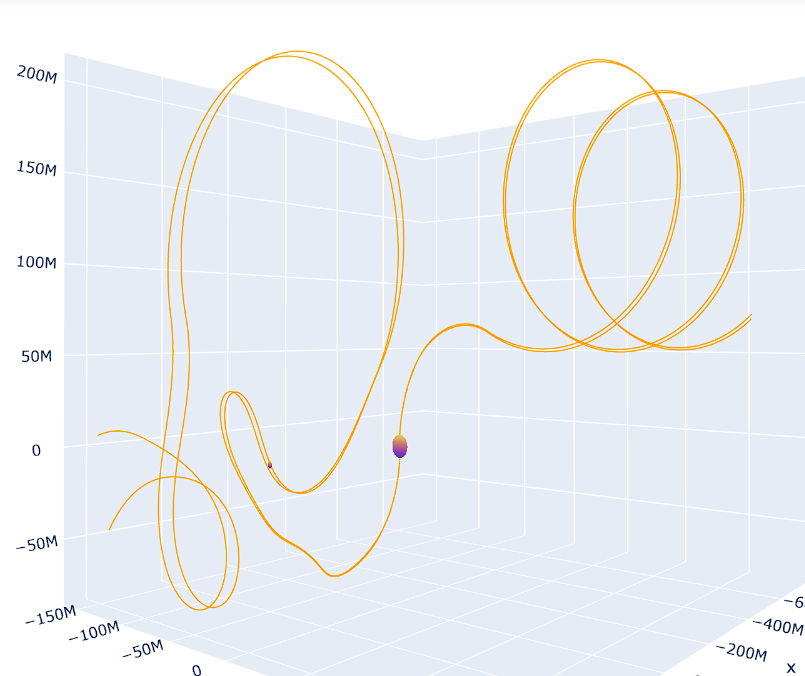

B_imf_xyz = $(0, 0, -5)$ нТл
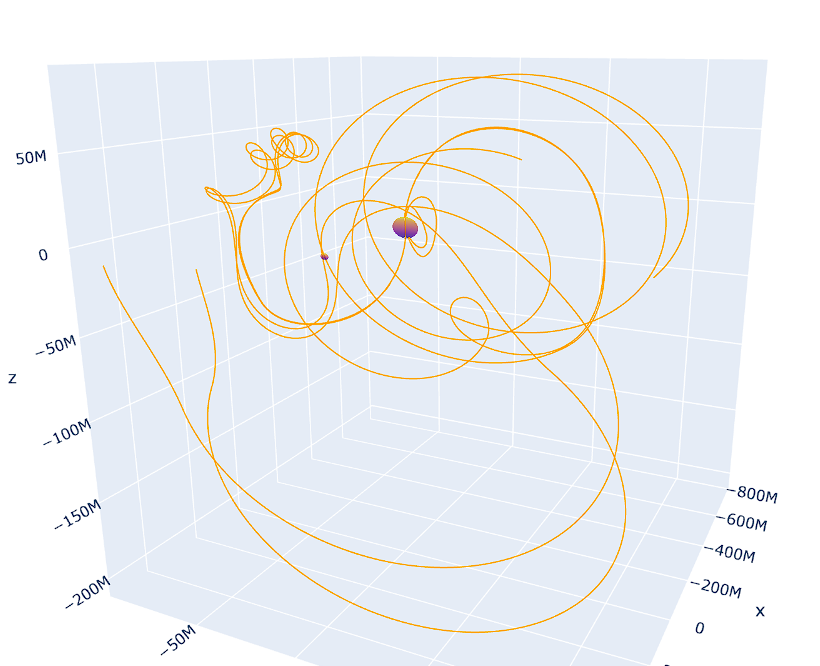

B_imf_xyz = $(5, 0, 0)$ нТл
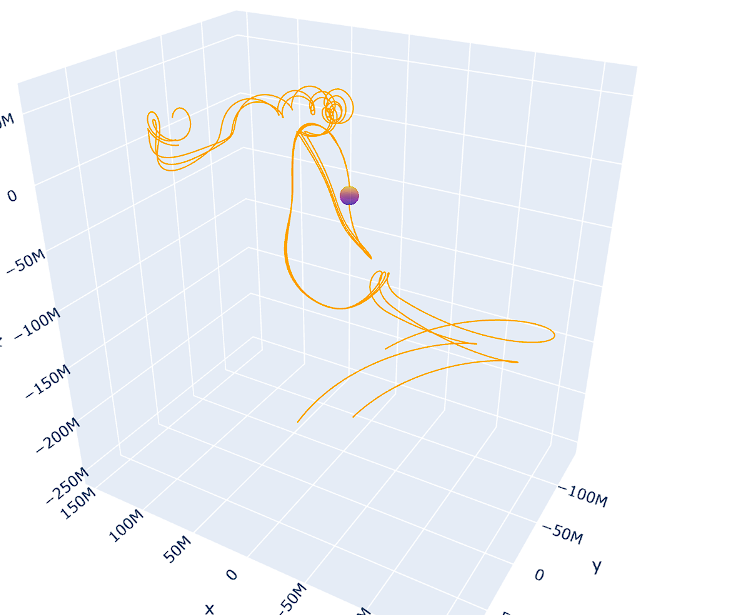
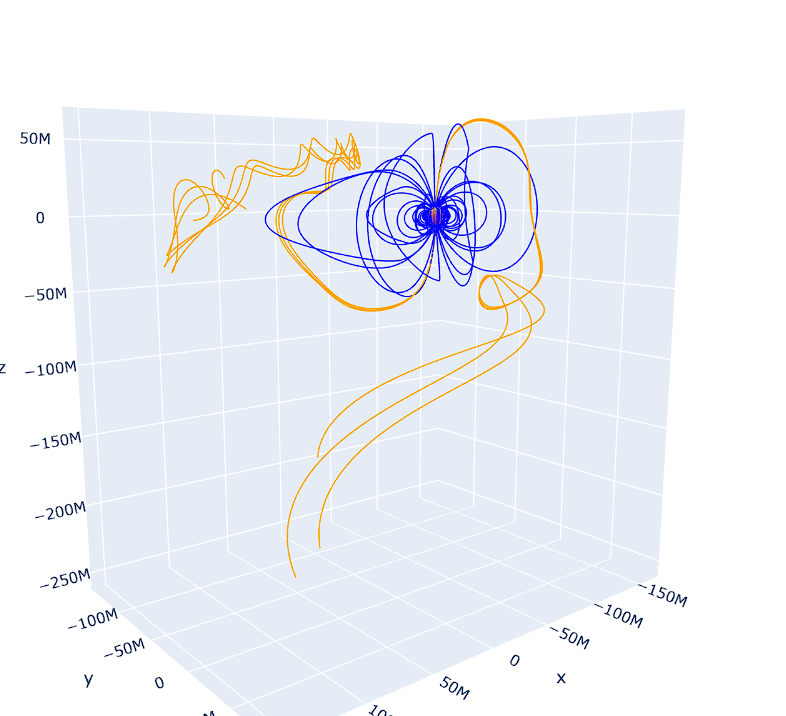

In [29]:
with open("progress.txt", "rb") as f:
        iterator = pickle.load(f)

In [30]:
next(iterator)

[0, 5, 0, 1, 2]

In [31]:
iterator.n

2513

In [32]:
iterator.count

0

In [162]:
C_i = 0.1
C_a = 0.9
lambd = 0.15
B_imf_xyz = np.array([0, 0, 5e-9])

thetas, phies, rs, theta_vs, phi_vs = magn.create_start_points_for_particles(r_upbound = 1.01*R_earth,
                            r_nums=1, thetha_nums=1, phi_nums=1, thetha_v_nums=1, phi_v_nums=1)
theta, phi, r, theta_v, phi_v = thetas[0], phies[0], rs[0], theta_vs[0], phi_vs[0] 
x, y, z = r*sin(theta)*cos(phi), r*sin(theta)*sin(phi), r*cos(theta)
x_M, y_M, z_M = z, y, -(x+b)
point_xyz = np.array([x_M, y_M, z_M])
point = magn.decart_to_sphere(*point_xyz)

In [206]:
%timeit magn.conf_B_tail(point, lambd)

111 µs ± 962 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [181]:
%timeit magn.conf_B_cfi_N(point)

108 µs ± 998 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [144]:
rho, phi, z = magn.spher_to_cyl(point)

B_rho = 0
B_phi = 0
B_z = 0

jv_1x_0 = j1(magn.x_0[:N] * rho / R_m)
jv_1x_1 = j1(magn.x_1[:N] * rho / R_m)
jv_0x_1 = j0(magn.x_1[:N] * rho / R_m)
jv_0x_0 = j0(magn.x_0[:N] * rho / R_m)
jv_2x_1 = jv(2, magn.x_1[:N] * rho / R_m)

cos_phi = np.array([cos(phi)]*N)
sin_phi = np.array([sin(phi)]*N)
expx_1 = np.exp(-magn.x_1[:N] * z / R_m)
expx_0 = np.exp(-magn.x_0[:N] * z / R_m)
explambdx_1 = np.exp(-lambd * magn.x_1[:N] * z / R_m)
explambdx_0 = np.exp(-lambd * magn.x_0[:N] * z / R_m)

mu_0_arr = np.array([mu_0 / (4 * np.pi)]*magn.N)
mu_0_arr * (magn.x_0 / magn.R_m_arr * magn.m_x_arr * magn.a_0 * jv_1x_0 * expx_0
                                             + 0.5 * magn.x_1 / magn.R_m_arr * magn.a_1 * magn.m_z_arr * cos_phi * (
                                                         jv_2x_1 - jv_0x_1) * expx_1
                                             + 0.5 * magn.x_1 / magn.R_m_arr * magn.a_1 * magn.m_y_arr * sin_phi * (
                                                         jv_2x_1 - jv_0x_1) * expx_1
                                             )

array([ 7.13779339e-08,  3.26728337e-07,  7.80123779e-07,  1.32296973e-06,
        1.86364967e-06,  2.25925661e-06,  2.39077165e-06,  2.10750881e-06,
        1.29747833e-06, -9.44480864e-08])

In [151]:
x_0 = magn.x_0
R_m_arr = magn.R_m_arr
m_x_arr = magn.m_x_arr
m_y_arr = magn.m_y_arr
m_z_arr = magn.m_z_arr
a_0 = magn.a_0
x_1 = magn.x_1
a_1 = magn.a_1


In [153]:
ne.evaluate("mu_0_arr * (x_0 / R_m_arr * m_x_arr * a_0 * jv_1x_0 * expx_0 \
                                             + 0.5 * x_1 / R_m_arr * a_1 * m_z_arr * cos_phi * ( \
                                                         jv_2x_1 - jv_0x_1) * expx_1 \
                                             + 0.5 * x_1 / R_m_arr * a_1 * m_y_arr * sin_phi * ( \
                                                         jv_2x_1 - jv_0x_1) * expx_1 \
                                             )")

array([ 7.13779339e-08,  3.26728337e-07,  7.80123779e-07,  1.32296973e-06,
        1.86364967e-06,  2.25925661e-06,  2.39077165e-06,  2.10750881e-06,
        1.29747833e-06, -9.44480864e-08])

In [18]:
R_m / R_earth

16.0

In [20]:
%timeit magn.x_0 / R_m

1.39 µs ± 9.29 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [19]:
%timeit magn.x_0 / 16 * R_earth

2.91 µs ± 185 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
magn.a_0

array([-3.43483761e-16, -2.38280027e-16, -1.26746396e-16, -6.24379444e-17,
       -2.86281968e-17, -1.28674798e-17, -5.52275543e-18, -2.39322161e-18,
       -9.78464221e-19, -4.24171613e-19])

In [29]:
N=10

In [30]:
rho, phi, z = magn.spher_to_cyl(point)

B_rho = 0
B_phi = 0
B_z = 0

jv_1x_0 = j1(magn.x_0[:N] * rho / R_m)
jv_1x_1 = j1(magn.x_1[:N] * rho / R_m)
jv_0x_1 = j0(magn.x_1[:N] * rho / R_m)
jv_0x_0 = j0(magn.x_0[:N] * rho / R_m)
jv_2x_1 = jv(2, magn.x_1[:N] * rho / R_m)

cos_phi = cos(phi)
sin_phi = sin(phi)
expx_1 = np.exp(-magn.x_1[:N] * z / R_m)
expx_0 = np.exp(-magn.x_0[:N] * z / R_m)
explambdx_1 = np.exp(-lambd * magn.x_1[:N] * z / R_m)
explambdx_0 = np.exp(-lambd * magn.x_0[:N] * z / R_m)

In [32]:
jv_1x_0

array([0.12005595, 0.21604518, 0.30482856, 0.38442483, 0.45270299,
       0.50780822, 0.54828343, 0.57313191, 0.58185337, 0.5744593 ])

In [33]:
magn.x_0

array([ 3.83170597,  7.01558667, 10.17346814, 13.32369194, 16.47063005,
       19.61585851, 22.76008438, 25.90367209, 29.04682853, 32.18967991])

In [36]:
magn.a_0

array([-3.43483761e-16, -2.38280027e-16, -1.26746396e-16, -6.24379444e-17,
       -2.86281968e-17, -1.28674798e-17, -5.52275543e-18, -2.39322161e-18,
       -9.78464221e-19, -4.24171613e-19])

In [199]:
R_ms = np.array([R_m]*N)

In [41]:
%timeit mu_0 / (4 * np.pi)

172 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [39]:
%timeit R_m_arr = np.array([R_m]*N)

1.62 µs ± 24.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [49]:
%timeit magn.x_0 * magn.a_0 * jv_1x_0 / R_ms

2.4 µs ± 54.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [50]:
%timeit magn.x_0 * magn.a_0 * jv_1x_0 / R_m

2.62 µs ± 27.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [42]:
%timeit mu_0 / (4 * np.pi) * magn.x_0 * magn.a_0 * jv_1x_0 / R_m * m_x

5.04 µs ± 62.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [31]:
%timeit magn.x_0 / R_m * m_x * magn.a_0 * jv_1x_0

3.87 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [44]:
%timeit 1 / rho * magn.x_0

1.82 µs ± 18.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [ ]:
def conf_B_tail(self, point, lambd, N=10, eps=10):
        rho, phi, z = self.spher_to_cyl(point)

        B_rho = 0
        B_phi = 0
        B_z = 0

        jv_1x_0 = j1(self.x_0[:N] * rho / R_m)
        jv_1x_1 = j1(self.x_1[:N] * rho / R_m)
        jv_0x_1 = j0(self.x_1[:N] * rho / R_m)
        jv_0x_0 = j0(self.x_0[:N] * rho / R_m)
        jv_2x_1 = jv(2, self.x_1[:N] * rho / R_m)

        cos_phi = cos(phi)
        sin_phi = sin(phi)
        expx_1 = np.exp(-self.x_1[:N] * z / R_m)
        expx_0 = np.exp(-self.x_0[:N] * z / R_m)
        explambdx_1 = np.exp(-lambd * self.x_1[:N] * z / R_m)
        explambdx_0 = np.exp(-lambd * self.x_0[:N] * z / R_m)
        
        

        res = np.sum([(mu_0 / (4 * np.pi) * (self.x_0 / R_m * m_x * self.a_0 * jv_1x_0 * expx_0
                                             + 0.5 * self.x_1 / R_m * self.a_1 * m_z * cos_phi * (
                                                         jv_2x_1 - jv_0x_1) * expx_1
                                             + 0.5 * self.x_1 / R_m * self.a_1 * m_y * sin_phi * (
                                                         jv_2x_1 - jv_0x_1) * expx_1
                                             )
                       + lambd * mu_0 / (4 * np.pi) * (self.x_0 / R_m * m_x * self.a_0 * jv_1x_0 * explambdx_0
                                                       + 0.5 * self.x_1 / R_m * self.a_1 * m_z * cos_phi * (
                                                                   jv_2x_1 - jv_0x_1) * explambdx_1
                                                       + 0.5 * self.x_1 / R_m * self.a_1 * m_y * sin_phi * (
                                                                   jv_2x_1 - jv_0x_1) * explambdx_1
                                                       )
                       ),
                      (mu_0 / (4 * np.pi) * (1 / rho * self.a_1 * m_z * sin_phi * jv_1x_1 * expx_1
                                             - 1 / rho * self.a_1 * m_y * cos_phi * jv_1x_1 * expx_1
                                             )
                       + lambd * mu_0 / (4 * np.pi) * (1 / rho * self.a_1 * m_z * sin_phi * jv_1x_1 * explambdx_1
                                                       - 1 / rho * self.a_1 * m_y * cos_phi * jv_1x_1 * explambdx_1
                                                       )
                       ),
                      (mu_0 / (4 * np.pi) * (self.x_0 / R_m * m_x * self.a_0 * jv_0x_0 * expx_0
                                             + self.x_1 / R_m * self.a_1 * m_z * cos_phi * jv_1x_1 * expx_1
                                             + self.x_1 / R_m * self.a_1 * m_y * sin_phi * jv_1x_1 * expx_1
                                             )
                       + mu_0 / (4 * np.pi) * (self.x_0 / R_m * m_x * self.a_0 * jv_0x_0 * explambdx_0
                                               + self.x_1 / R_m * self.a_1 * m_z * cos_phi * jv_1x_1 * explambdx_1
                                               + self.x_1 / R_m * self.a_1 * m_y * sin_phi * jv_1x_1 * explambdx_1
                                               )
                       )], axis=1) / 2